In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm

sbn.set()

MISSING

- Warmup needed for Metropolis-Hastings in (1)?

<h3>(1) Metropolis Hastings</h3>

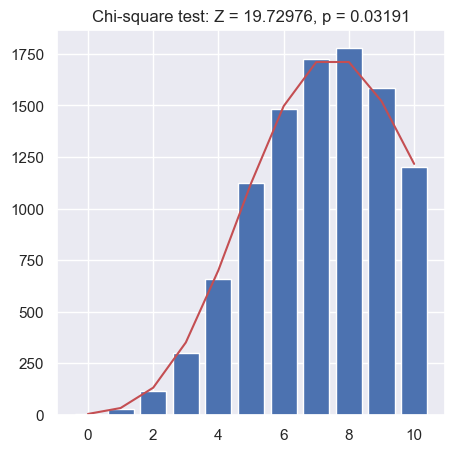

In [2]:
def analytical_solution(A = 8, m = 10):
    var = [g(A, i) for i in range(m)]
    return var / np.sum(var)

def sample_dxi(m):
    U = np.random.randint(-m, m + 1, size = 1)   
    return U
    
def g(A, i):
    return (A ** i) / np.math.factorial(i)

def metropolis_hastings(A, m = 10, n = 10000):
    # Initialize states
    X = np.zeros(n).astype(int)
    i = 0
    j = 0

    X[0] = i

    for j in range(0, n - 1):
        Xi = X[j]

        dXi = sample_dxi(m)

        Y = int(np.mod(Xi + dXi, m + 1)) # Propose to jump to Yi
        
        gy = g(A = A, i = Y)
        gxi = g(A = A, i = Xi)

        if  gy >= gxi:
            accept = True
        else: 

            U = np.random.uniform(0, 1, 1)
            
            if gy / gxi > U:
                accept = True
            else:
                accept = False

        if accept:
            X[j + 1] = Y
        else:
            X[j + 1] = Xi

    return X

m = 10        
A = 8
n = 10000
X = metropolis_hastings(A = A, m = m, n = n)

X_hist =  np.histogram(X, bins = m + 1, density=0)[0] 

P = analytical_solution(m = m + 1)

test = stats.chisquare(X_hist, P * n)

Z = test.statistic
p = test.pvalue

fig, ax = plt.subplots(1, figsize = (5, 5))
ax.plot(P * n, color = 'r')
ax.bar(x = np.arange(0, m + 1, 1), height = X_hist)
ax.set_title(f'Chi-square test: Z = {Z:.5f}, p = {p:.5f}')

plt.show()

In [3]:
# Calculate p-values for multiple runs
runs = 1000
p_vals = np.zeros(runs)
step = 4
n = 20000

for r in tqdm(range(runs)):
    X = metropolis_hastings(A = A, m = m, n = n)[::step]

    X_hist =  np.histogram(X, bins = m + 1, density=0)[0] 

    P = analytical_solution(m = m + 1)

    test = stats.chisquare(X_hist, P * (n/step))
    p = test.pvalue

    p_vals[r] = p

p_hist = np.histogram(p_vals, bins = 10)[0]

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.hist(p_vals, bins = 10)

plt.show()

 22%|██▏       | 215/1000 [00:28<01:44,  7.53it/s]


KeyboardInterrupt: 

The p-values are somewhat uniformly distributed when we take every fourth value in the simulation. This is likely due to the variables being too dependent on the next value random variate so we can enforce more independence by taking values farther apart. 

<h3>(2) Joint occupied lines </h3>

In [4]:
def sample_dx(range_, n = 2):
    U = np.random.randint(-range_, range_ + 1, size = n)   
    return U

def g_joined(A1, A2, i, j):
    return ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))

def metropolis_hastings_joined(A = 8, m = 10, N = 10000, mode = 'ordinary'):
    X = np.zeros((N, 2)).astype(int)
    i = 0
    j = 0

    X[0] = [i, j]

    for n in range(0, N - 1):
        Xn = X[n]

        if mode == 'ordinary':

            proposal_found = False
            while not proposal_found:
                dXn = sample_dx(range_ = m, n = 2)

                Y = np.mod(Xn + dXn, m + 1).astype(int) # Propose to jump to Y

                if Y.sum() <= m:
                    proposal_found = True
            
            gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
            gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

            if  gy >= gx:
                accept = True
            else: 

                U = np.random.uniform(0, 1, 1)
            
                if gy / gx > U:
                    accept = True
                else:
                    accept = False

            if accept:
                X[n + 1] = Y
            else:
                X[n + 1] = Xn

        elif mode == 'coordinatewise':
            Yk = [Xn]
            
            # First acceptance in x-direction, then y-direction
            for k in range(2):
                
                proposal_found = False

                while not proposal_found:
                    dXnk = sample_dx(range_ = m, n = 1)

                    Y = Yk[k].copy() # Get the current state
                    Y[k] += dXnk # Add the state at the coordinate
                    Y = np.mod(Y, m)

                    if Y.sum() <= m:
                        proposal_found = True

                gy = g_joined(A1 = A[0], A2 = A[1], i = Y[0], j = Y[1])
                gx = g_joined(A1 = A[0], A2 = A[1], i = Xn[0], j = Xn[1])

                if  gy >= gx:
                    accept = True
                else: 
                    U = np.random.uniform(0, 1, 1)
        
                    if gy / gx > U:
                        accept = True
                    else:
                        accept = False

                Yk.append(Y)
            
            X[n] = Y[1]
    return X
    
def analytical_solution_joined(A = [4, 4], m = 10):
    P = np.zeros((m + 1, m + 1))
    A1 = A[0]
    A2 = A[1]

    for i in range(m + 1):
        for j in range(m + 1):
            if (i + j) <= m:
                P[i, j] = ((A1 ** i) / np.math.factorial(i)) * ((A2 ** j) / np.math.factorial(j))


    #var = [g(A, i) for i in range(m)]
    return P / np.sum(P)


X = metropolis_hastings_joined(A = [4, 4], m = 10, N = 10000, mode = 'coordinatewise')
P = analytical_solution_joined(A = [4, 4], m = 10)

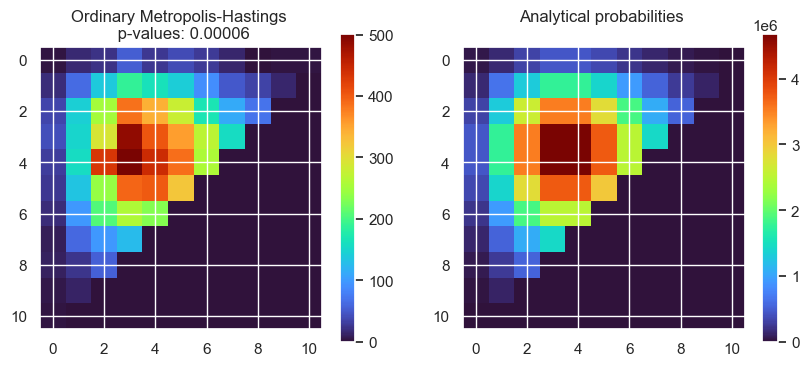

In [98]:
N = 10000

X = metropolis_hastings_joined(A = [4, 4], m = 10, N = N, mode = 'ordinary')
P = analytical_solution_joined(A = [4, 4], m = 10) * N
X_hist = np.histogram2d(x = X[:, 0], y = X[:, 1], bins = np.arange(0, m + 2, 1), density=False)[0].astype(int)

# Remove zeroes
f_obs = X_hist.flatten()[np.where(X_hist.flatten() > 0)[0]]
f_exp = P.flatten()[np.where(P.flatten() > 0)[0]]

if f_obs.shape < f_exp.shape:
    f_exp = f_exp[:f_obs.shape[0]]
elif f_obs.shape > f_exp.shape:
    f_obs = f_obs[:f_exp.shape[0]]

# Chi square test
test = stats.chisquare(f_obs = f_obs, f_exp = f_exp)

fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ax[0].set_title(f'Ordinary Metropolis-Hastings \n p-values: {test.pvalue:.5f}')
im1 = ax[0].imshow(X_hist, cmap = 'turbo')
plt.colorbar(im1, ax=ax[0])

ax[1].set_title(f'Analytical probabilities \n')
im2 = ax[1].imshow(P * n, cmap = 'turbo')
plt.colorbar(im2, ax=ax[1])

plt.show()



In [106]:
# Calculate p-values 
runs = 1000
p_vals = np.ones(runs)
P = analytical_solution_joined(A = [4, 4], m = 10) * N

for r in tqdm(range(runs)):
    X = metropolis_hastings_joined(A = [4, 4], m = 10, N = N, mode = 'ordinary')
    X_hist = np.histogram2d(x = X[:, 0], y = X[:, 1], bins = np.arange(0, m + 2, 1), density=False)[0].astype(int)

    # Remove zeroes
    f_obs = X_hist.flatten()[np.where(X_hist.flatten() > 0)[0]]
    f_exp = P.flatten()[np.where(P.flatten() > 0)[0]]

    if f_obs.shape < f_exp.shape:
        f_exp = f_exp[:f_obs.shape[0]]
    elif f_obs.shape > f_exp.shape:
        f_obs = f_obs[:f_exp.shape[0]]

    # Chi square test
    try: 
        test = stats.chisquare(f_obs = f_obs, f_exp = f_exp)
    except:
        continue
    else:
        p_vals[r] = test.pvalue



100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


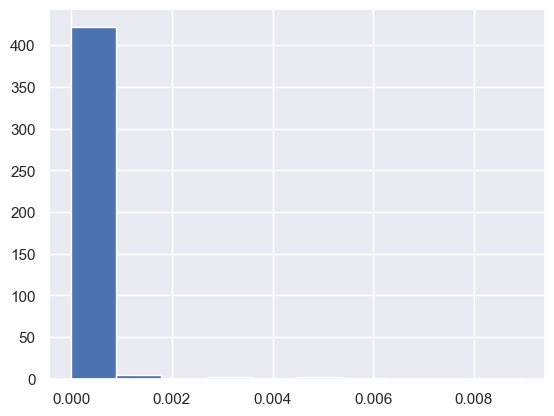

In [107]:
n_bins = 10
ps = p_vals[p_vals < 1.0]

plt.hist(x = ps, bins = n_bins)
plt.show()

<h3>(3) Bayesian statistical problem </h3>

In [14]:
# A) 
eta, gamma = np.random.normal(size = 2)

theta = np.exp(eta)
psi = np.exp(gamma)

print(f'Sample (theta, gamma) = ({theta:.3f}, {gamma:.3f})')

Sample (theta, gamma) = (0.594, -0.959)


In [15]:
# B)
n = 10
X = np.random.normal(loc = theta, scale = psi, size = n)

X

array([0.62220563, 0.65771862, 0.44860369, 0.14776688, 0.93224044,
       0.79442993, 1.00630435, 0.79728159, 0.14652103, 0.57339356])

In [ ]:
# C) 